**This notebook deals with visualisation of the massive GFW dataset, using Kepler.gl and DataShader.**

### Imports and Setup

In [0]:
!pip install quilt3 datashader
#restart runtime after this completes

In [0]:
import dask
import dask.dataframe as dd
import pandas as pd
from dask.diagnostics import ProgressBar
import pandas as pd
import datashader as ds
import datashader.transfer_functions as tf
from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, Hot, viridis, inferno
from shapely.geometry import LineString
import quilt3
import os

In [2]:
#download data from quilt to runtime
quilt3.Package.install("aionthebeach/global-fishing-watch", registry="s3://ai-on-the-beach", dest='./Global-Fishing-Watch')

Loading manifest: 100%|██████████| 2558/2558 [00:00<00:00, 31097.74entries/s]
Copying objects: 100%|██████████| 4.56G/4.56G [01:03<00:00, 72.3MB/s]
Hashing: 0.00B [00:00, ?B/s]


### Main

#### Exploratory Data Analysis


---




* About the data: [Global Fishing Watch](https://globalfishingwatch.org/datasets-and-code/vessel-identity/) 
* The data available is from 2012-01-01 to 2018-12-31, 7 years of data
* A total of 103,599 unique vessels!
* Field Descriptions:
> * date : datetime (UTC format)
> * lat_bin, lon_bin : locations (float)
> * mmsi : unique vessel id (integer)
> * fishing_hours : total fishing time spent by the vessel (float)

* The locations are casted to int, so they've lost their precision. We divide it by 10 to recover them






**Reading Data**


---



In [37]:
#read data from runtime
df = dd.read_csv("Global-Fishing-Watch/*/*.csv",
                 parse_dates = ["date"])
df.head()

,date,lat_bin,lon_bin,mmsi,fishing_hours
0,2012-01-01 00:00:00+00:00,-461,-607,416755000,2.457917
1,2012-01-01 00:00:00+00:00,-461,-607,440548000,2.400417
2,2012-01-01 00:00:00+00:00,-460,-607,440548000,1.614444
3,2012-01-01 00:00:00+00:00,-460,-607,416032500,11.497083
4,2012-01-01 00:00:00+00:00,-459,-607,416842000,11.521944


In [38]:
# recorrecting locations
df["lon_bin"] = df["lon_bin"]/10
df["lat_bin"] = df["lat_bin"]/10
df.head()

,date,lat_bin,lon_bin,mmsi,fishing_hours
0,2012-01-01 00:00:00+00:00,-46.1,-60.7,416755000,2.457917
1,2012-01-01 00:00:00+00:00,-46.1,-60.7,440548000,2.400417
2,2012-01-01 00:00:00+00:00,-46.0,-60.7,440548000,1.614444
3,2012-01-01 00:00:00+00:00,-46.0,-60.7,416032500,11.497083
4,2012-01-01 00:00:00+00:00,-45.9,-60.7,416842000,11.521944


**Some Basic Statistics**


---



> Let's find out the most hardworking vessels and total unique vessels over this 7 year span

In [0]:
#build computational graphs
unique_vessels = df.mmsi.nunique()

vessel_activity = df.groupby(by="mmsi").agg({"fishing_hours":"sum"})
vessel_activity = vessel_activity.reset_index()

In [0]:
with ProgressBar():
  unique_vessels, vessel_activity = dask.compute(unique_vessels, vessel_activity)
print("Unique Vessels: {}".format(unique_vessels))
vessel_activity.head()

[########################################] | 100% Completed |  5min 11.2s
Unique Vessels: 103599


,mmsi,fishing_hours
0,345,425.199444
1,416,157.663472
2,424,52.689306
3,712,71.948333
4,722,78.173194


In [0]:
#most active vessels
top_10_active_vessels = vessel_activity.nlargest(10, "fishing_hours")
top_10_active_vessels

,mmsi,fishing_hours
17228,440703000,49041.395278
17387,441811000,47537.812500
17209,440648000,46954.171667
17256,440807000,46861.740278
17240,440765000,46576.727500
17388,441812000,46370.726806
17274,440886000,46335.886806
17390,441825000,45791.314306
17199,440620000,45631.580139
17289,440935000,45591.080417


#### Exploring a Single Vessel


---
> Attempt to explore the trajectory of the most active vessel over time

In [0]:
vessel = df[df.mmsi==440703000] #this is the most activate vessel

In [0]:
from itertools import groupby  

def getVesselTrajectories(df):
  '''
  converts vessel pings to trajectories
  '''
  geometry = [xy for xy in zip(df.lon_bin, df.lat_bin)]
  geometry = [i[0] for i in groupby(geometry)] 

  #if there are less than two location pings for this ship, consider it a bad day to go fishing!
  if(len(geometry)<2):
    return
  geometry = LineString(geometry)

  #some of these vessels seems to travel across the globe in a single day. Remove anomalous trajectories
  if(geometry.length>10):
    return 
  
  geometry = geometry.simplify(0.000001, preserve_topology=False).wkt
  return pd.DataFrame(data=[[geometry, df['fishing_hours'].sum()]], columns=["geometry", "total_fishing_hours"])


In [0]:
meta = {
    "geometry": "string",
    "total_fishing_hours":"float"
}

In [0]:
with ProgressBar():
  daily_vessel_trajectories = vessel.groupby(by="date").apply(getVesselTrajectories, meta=meta).compute()

[########################################] | 100% Completed |  1min 14.3s


In [0]:
daily_vessel_trajectories = daily_vessel_trajectories.reset_index()
daily_vessel_trajectories = daily_vessel_trajectories.sort_values(by=["date"], ignore_index=True)
daily_vessel_trajectories = daily_vessel_trajectories.drop(columns=["level_1"])
daily_vessel_trajectories.head()

,date,geometry,total_fishing_hours
0,2018-01-01 00:00:00+00:00,"LINESTRING (179.4 5.8, 179.3 5.8, 179.5 5.8, 1...",23.813472
1,2018-01-03 00:00:00+00:00,"LINESTRING (-179.7 5.6, -180 5.6, -179.7 5.7, ...",23.887778
2,2018-01-05 00:00:00+00:00,"LINESTRING (-179.3 5.5, -179.2 5.5, -179.2 5.6...",23.872361
3,2018-01-06 00:00:00+00:00,"LINESTRING (-179 6.1, -179.2 6.1, -178.5 6.1, ...",23.974306
4,2018-01-07 00:00:00+00:00,"LINESTRING (-178.5 6.4, -178.7 6.5, -178.5 6.5...",23.991389


In [0]:
daily_vessel_trajectories.to_csv("vessel_trajectory.csv", index=False)

#### Plotting GFW Centroids using DataShader


---


Selecting a nice looking color map. Then plot all points on a canvas. 

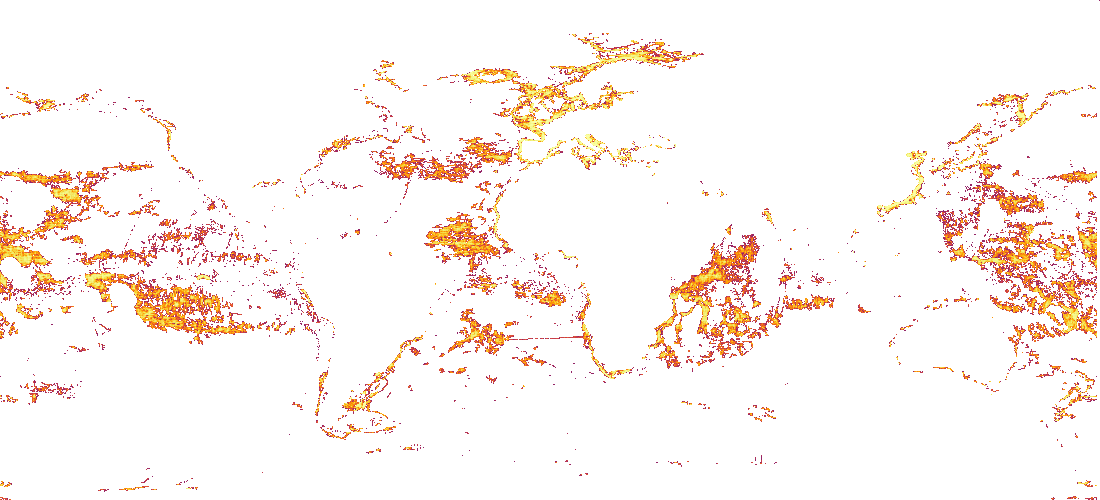

In [248]:
background = "black"
export = partial(export_image, background = background)
cm = partial(colormap_select, reverse=(background!="black"))
cvs = ds.Canvas(plot_width=1100, plot_height=500)

#uncomment for debuggin with smaller dataset
# df = df.get_partition(0)

with ProgressBar():
  
  agg = cvs.points(df, 'lon_bin', 'lat_bin')
  plot = tf.shade(agg, cmap=cm(viridis,0.3), how='log')

plot

In [0]:
export(plot, "GFW_centroids_plot")

> Let's get monthly vessel activities across the globe to create a timelapse! (WIP)

In [0]:
def exportPlot(df):
  
  if(df.shape[0]<=2):
    return
  
  name = str(df['date'].iloc[0])[:7]
  background = "black"
  export = partial(export_image, background = background)
  cm = partial(colormap_select, reverse=(background!="black"))
  cvs = ds.Canvas(plot_width=1100, plot_height=500, x_range=(-180.0, 180.0), y_range=(-90.0, 90.0))  
  agg = cvs.points(df, 'lon_bin', 'lat_bin')
  export(tf.shade(agg, cmap=cm(inferno,0.4), how='eq_hist'), "images/"+name)
  return

In [40]:
os.mkdir("images")
df["month"] = df["date"].map(lambda x: str(x)[:7])
with ProgressBar():
  df.groupby(by="month").apply(exportPlot).compute()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  This is separate from the ipykernel package so we can avoid doing imports until


[########################################] | 100% Completed | 17min 12.1s


> Now, we'll use this OpenCV snippet to stich the images into a video.

ToDo:

1. Fix Video Shakiness
2. Add map background to datashader view


In [0]:
def rescale_frame(frame, percent=75):
    width = int(frame.shape[1] * percent/ 100)
    height = int(frame.shape[0] * percent/ 100)
    dim = (width, height)
    return cv2.resize(frame, dim, interpolation =cv2.INTER_AREA)

In [0]:
import cv2
import numpy as np
import os
from os.path import isfile, join

pathIn= './images/'
pathOut = 'GFW_timelapse.mp4'
fps = 10
frame_array = []
files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]


monthDict={"01":'Jan', 
           "02":'Feb', 
           "03":'Mar', 
           "04":'Apr', 
           "05":'May', 
           "06":'Jun', 
           "07":'Jul', 
           "08":'Aug', 
           "09":'Sep', 
           "10":'Oct', 
           "11":'Nov', 
           "12":'Dec'}

#for sorting the file names properly
files = sorted(files)
sizes = []
for i in range(len(files)):
    filename=pathIn + files[i]
    #reading each files
    img = cv2.imread(filename)
    
    height, width, layers = img.shape
    size = (1920, 1080)
    
    img = cv2.resize(img, size)
    

    # add text centered on image
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = monthDict[files[i][5:7]] +" "+files[i][:4]
    
    textsize = cv2.getTextSize(text, font, 1, 2)[0]
    textX = (img.shape[1] - textsize[0]) //2
    textY = int((img.shape[0] + textsize[1]) * (5/6))
    
    cv2.putText(img, text, (textX, textY), font, 1, (255, 255, 255), 2)
    #inserting the frames into an image array
    frame_array.append(img)

out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'MP4V'), fps, size)
for i in range(len(frame_array)):
    # writing to a image array
    out.write(frame_array[i])
out.release()

> Presenting GFW!

![Global Fish Watch](https://drive.google.com/uc?export=view&id=1LXVNZb6xIEz28ptQcGSAr9vYZdgdEOBd)

#### Global Fishing Watch Aggregated Views


---

*   After aggregating data by location, we export GFW_processed.csv and plot it on Kepler.
*   You could also do the same using Kepler Jupyter Plugin if you are not using colab.



In [0]:
df = df.groupby(["lat_bin", "lon_bin"]).agg({"date":"count"})
with ProgressBar():
  df = df.compute()

df = df.reset_index()
df.rename(columns={"lat_centroid":"latitude", "lon_centroid":"longitude", "date":"intensity"}, inplace=True)

print("Data Size: {}".format(df.shape[0]))
df.to_csv("GFW_processed.csv", index=False)
df.head()

[########################################] | 100% Completed |  2min  8.5s


> Here's how it looks after plotting the data in Kepler. I've uploaded the png and rendered it here.

![picture](https://drive.google.com/uc?export=view&id=1tTF2vpDTn_3hgmnNo1TUiK0s0RCtfKqN)